# 🚀 Cryptocurrency Price Prediction with Polynomial Regression

## Project Overview

**Objective**: Predict the actual closing price of cryptocurrencies (Bitcoin/Ethereum) using Polynomial Regression.

### 🎯 Polynomial Regression Advantages:
- **Captures non-linear relationships**: Price movements follow curves, not straight lines
- **Simple yet powerful**: Easy to understand and interpret
- **Flexible**: Control complexity with polynomial degree
- **Fast training**: Efficient for large datasets

### 🔧 Key Features:
- **44 technical indicators**: RSI, MACD, Bollinger Bands, ROC, ATR, Volume indicators
- **Polynomial features**: Transform features to capture non-linear patterns
- **Degree optimization**: Test different polynomial degrees (1-4)
- **Regression metrics**: MAE, MSE, RMSE, R² score
- **Dual models**: Separate optimized models for Bitcoin and Ethereum

### 📊 Workflow:
1. Load historical crypto data
2. Engineer 44 technical features
3. Create polynomial features (degree 2-3)
4. Train polynomial regression models
5. Evaluate with regression metrics
6. Generate price predictions

---

In [13]:
# ============================================================================
# Import all necessary libraries for the project
# ============================================================================

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Polynomial Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error
)

# Model persistence
import joblib
import os
from datetime import datetime

# Technical Indicators
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ All libraries imported successfully!")
print("📊 Using Polynomial Regression for price prediction")

✅ All libraries imported successfully!
📊 Using Polynomial Regression for price prediction


In [14]:
# ============================================================================
# Load and explore the cryptocurrency dataset
# ============================================================================

# Load the dataset  
df = pd.read_csv('combined_crypto_dataset.csv')

# Display basic information
print("="*60)
print("📊 DATASET OVERVIEW")
print("="*60)
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

print("\n" + "="*60)
print("📈 DATA QUALITY CHECK")
print("="*60)
print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nCryptocurrency distribution:")
print(df['Name'].value_counts())

print(f"\nDate range:")
df['Date'] = pd.to_datetime(df['Date'])
print(f"From: {df['Date'].min()}")
print(f"To: {df['Date'].max()}")
print(f"Total days: {(df['Date'].max() - df['Date'].min()).days}")

print(f"\nPrice statistics:")
print(df.groupby('Name')['Close'].describe())

print("\n✅ Data loaded successfully!")

📊 DATASET OVERVIEW
Dataset Shape: (5151, 10)

Columns: ['SNo', 'Name', 'Symbol', 'Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']

First few rows:
   SNo     Name Symbol                 Date        High         Low        Open       Close  Volume     Marketcap
0    1  Bitcoin    BTC  2013-04-29 23:59:59  147.488007  134.000000  134.444000  144.539993     0.0  1.603769e+09
1    2  Bitcoin    BTC  2013-04-30 23:59:59  146.929993  134.050003  144.000000  139.000000     0.0  1.542813e+09
2    3  Bitcoin    BTC  2013-05-01 23:59:59  139.889999  107.720001  139.000000  116.989998     0.0  1.298955e+09
3    4  Bitcoin    BTC  2013-05-02 23:59:59  125.599998   92.281898  116.379997  105.209999     0.0  1.168517e+09
4    5  Bitcoin    BTC  2013-05-03 23:59:59  108.127998   79.099998  106.250000   97.750000     0.0  1.085995e+09

📈 DATA QUALITY CHECK

Missing values:
SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close      

In [15]:
# ============================================================================
# Create target variable for regression (predict next day's closing price)
# ============================================================================

# Sort by Name and Date
df = df.sort_values(['Name', 'Date']).reset_index(drop=True)

# Create target: Next day's closing price
df['Target'] = df.groupby('Name')['Close'].shift(-1)

# Remove last row for each crypto (no next day data)
df = df[df['Target'].notna()].copy()

print("="*60)
print("🎯 TARGET VARIABLE STATISTICS")
print("="*60)
print(f"\nTarget: Next day's closing price")
print(f"\nTarget statistics by crypto:")
print(df.groupby('Name')['Target'].describe())

print(f"\nPrice change distribution:")
df['Price_Change_Pct'] = ((df['Target'] - df['Close']) / df['Close']) * 100
print(df.groupby('Name')['Price_Change_Pct'].describe())

print("\n✅ Target variable created successfully!")

🎯 TARGET VARIABLE STATISTICS

Target: Next day's closing price

Target statistics by crypto:
           count         mean           std        min         25%          50%          75%           max
Name                                                                                                      
Bitcoin   2990.0  6713.486681  11299.393126  68.431000  430.918991  2295.694946  8577.107248  63503.457930
Ethereum  2159.0   384.088161    601.161412   0.434829   13.841400   198.872000   386.445556   4168.701049

Price change distribution:
           count      mean       std        min       25%       50%       75%        max
Name                                                                                    
Bitcoin   2990.0  0.274062  4.263925 -37.169541 -1.300694  0.188316  1.866916  42.968039
Ethereum  2159.0  0.566951  6.303562 -42.347220 -2.294092  0.071989  3.010868  50.732308

✅ Target variable created successfully!


In [16]:
# ============================================================================
# Feature Engineering: Create 44 comprehensive technical indicators
# ============================================================================

def calculate_rsi(data, window=14):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, fast=12, slow=26, signal=9):
    """Calculate MACD"""
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd - macd_signal
    return macd, macd_signal, macd_histogram

def engineer_features(df):
    """Create all 44 technical indicators"""
    df = df.copy()
    df = df.sort_values(['Name', 'Date']).reset_index(drop=True)
    
    feature_dfs = []
    
    for crypto in df['Name'].unique():
        crypto_df = df[df['Name'] == crypto].copy()
        
        # 1. Price change features (3)
        crypto_df['Daily_Return'] = ((crypto_df['Close'] - crypto_df['Open']) / crypto_df['Open']) * 100
        crypto_df['Price_Change'] = crypto_df['Close'].pct_change() * 100
        crypto_df['Volatility'] = ((crypto_df['High'] - crypto_df['Low']) / crypto_df['Close']) * 100
        
        # 2. Lagged features (5)
        for lag in [1, 2, 3, 5, 7]:
            crypto_df[f'Close_Lag_{lag}'] = crypto_df['Close'].shift(lag)
        
        # 3. Moving Averages (4)
        crypto_df['MA_7'] = crypto_df['Close'].rolling(window=7).mean()
        crypto_df['MA_20'] = crypto_df['Close'].rolling(window=20).mean()
        crypto_df['MA_30'] = crypto_df['Close'].rolling(window=30).mean()
        crypto_df['MA_50'] = crypto_df['Close'].rolling(window=50).mean()
        
        # 4. Moving Average Ratios (3)
        crypto_df['MA_Ratio_7_30'] = crypto_df['MA_7'] / crypto_df['MA_30']
        crypto_df['Price_to_MA7'] = crypto_df['Close'] / crypto_df['MA_7']
        crypto_df['Price_to_MA30'] = crypto_df['Close'] / crypto_df['MA_30']
        
        # 5. Bollinger Bands (4)
        crypto_df['Std_20'] = crypto_df['Close'].rolling(window=20).std()
        crypto_df['Upper_BB'] = crypto_df['MA_20'] + (2 * crypto_df['Std_20'])
        crypto_df['Lower_BB'] = crypto_df['MA_20'] - (2 * crypto_df['Std_20'])
        crypto_df['BB_Position'] = (crypto_df['Close'] - crypto_df['Lower_BB']) / (crypto_df['Upper_BB'] - crypto_df['Lower_BB'])
        
        # 6. Rate of Change (2)
        crypto_df['ROC_5'] = ((crypto_df['Close'] - crypto_df['Close'].shift(5)) / crypto_df['Close'].shift(5)) * 100
        crypto_df['ROC_10'] = ((crypto_df['Close'] - crypto_df['Close'].shift(10)) / crypto_df['Close'].shift(10)) * 100
        
        # 7. RSI (1)
        crypto_df['RSI_14'] = calculate_rsi(crypto_df['Close'], window=14)
        
        # 8. MACD (3)
        crypto_df['MACD'], crypto_df['MACD_Signal'], crypto_df['MACD_Histogram'] = calculate_macd(crypto_df['Close'])
        
        # 9. ATR (1)
        crypto_df['TR1'] = crypto_df['High'] - crypto_df['Low']
        crypto_df['TR2'] = abs(crypto_df['High'] - crypto_df['Close'].shift(1))
        crypto_df['TR3'] = abs(crypto_df['Low'] - crypto_df['Close'].shift(1))
        crypto_df['True_Range'] = crypto_df[['TR1', 'TR2', 'TR3']].max(axis=1)
        crypto_df['ATR_14'] = crypto_df['True_Range'].rolling(window=14).mean()
        crypto_df.drop(['TR1', 'TR2', 'TR3', 'True_Range'], axis=1, inplace=True)
        
        # 10. Volume features (5)
        crypto_df['Volume_Change'] = crypto_df['Volume'].pct_change() * 100
        crypto_df['Volume_MA_7'] = crypto_df['Volume'].rolling(window=7).mean()
        crypto_df['Volume_Ratio'] = crypto_df['Volume'] / crypto_df['Volume_MA_7']
        crypto_df['Volume_ROC_5'] = ((crypto_df['Volume'] - crypto_df['Volume'].shift(5)) / crypto_df['Volume'].shift(5)) * 100
        crypto_df['Volume_Spike'] = (crypto_df['Volume'] > crypto_df['Volume_MA_7'] * 1.5).astype(int)
        
        # 11. Additional indicators (9)
        crypto_df['HL_Spread'] = crypto_df['High'] - crypto_df['Low']
        crypto_df['Rolling_Volatility_7'] = crypto_df['Price_Change'].rolling(window=7).std()
        crypto_df['Rolling_Volatility_30'] = crypto_df['Price_Change'].rolling(window=30).std()
        crypto_df['MA_Cross_Signal'] = (crypto_df['MA_7'] > crypto_df['MA_30']).astype(int)
        crypto_df['Distance_MA7'] = ((crypto_df['Close'] - crypto_df['MA_7']) / crypto_df['MA_7']) * 100
        crypto_df['Distance_MA30'] = ((crypto_df['Close'] - crypto_df['MA_30']) / crypto_df['MA_30']) * 100
        crypto_df['Price_Direction'] = (crypto_df['Close'] > crypto_df['Close'].shift(1)).astype(int)
        crypto_df['Consecutive_Trend'] = crypto_df.groupby((crypto_df['Price_Direction'] != crypto_df['Price_Direction'].shift()).cumsum())['Price_Direction'].transform('count')
        crypto_df['Momentum'] = crypto_df['Close'] - crypto_df['Close'].shift(4)
        
        feature_dfs.append(crypto_df)
    
    df_features = pd.concat(feature_dfs, ignore_index=True)
    df_features = df_features.dropna().reset_index(drop=True)
    
    return df_features

# Apply feature engineering
print("="*60)
print("🔧 FEATURE ENGINEERING IN PROGRESS...")
print("="*60)
df_features = engineer_features(df)

print(f"\n✅ Created features")
print(f"📊 Dataset shape after feature engineering: {df_features.shape}")
print(f"🧹 Rows after removing NaN: {len(df_features)}")

# Display feature columns
feature_cols = [col for col in df_features.columns if col not in ['Name', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target', 'Symbol', 'symbol', 'SNo', 'Marketcap', 'Price_Change_Pct']]
print(f"\n📋 Total features: {len(feature_cols)}")

🔧 FEATURE ENGINEERING IN PROGRESS...

✅ Created features
📊 Dataset shape after feature engineering: (4858, 52)
🧹 Rows after removing NaN: 4858

📋 Total features: 40


In [17]:
# ============================================================================
# Split Data by Cryptocurrency and Clean
# ============================================================================

print("="*60)
print("🔄 SPLITTING DATA BY CRYPTOCURRENCY")
print("="*60)

# Define feature columns (exclude non-feature columns)
feature_cols = [col for col in df_features.columns if col not in 
                ['Name', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
                 'Target', 'Symbol', 'symbol', 'SNo', 'Marketcap', 'Price_Change_Pct']]

print(f"\n📋 Selected {len(feature_cols)} features for modeling")

# Split by cryptocurrency
btc_df = df_features[df_features['Name'] == 'Bitcoin'].copy()
eth_df = df_features[df_features['Name'] == 'Ethereum'].copy()

print(f"\n📊 Dataset sizes:")
print(f"   Bitcoin: {len(btc_df)} samples")
print(f"   Ethereum: {len(eth_df)} samples")

# Handle any remaining inf/NaN values
print(f"\n🧹 Cleaning data...")
for df_name, df_data in [('Bitcoin', btc_df), ('Ethereum', eth_df)]:
    # Replace inf with NaN
    df_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Fill NaN with forward fill then backward fill
    df_data[feature_cols] = df_data[feature_cols].fillna(method='ffill').fillna(method='bfill')
    
    # If still NaN, fill with median
    for col in feature_cols:
        if df_data[col].isnull().any():
            df_data[col].fillna(df_data[col].median(), inplace=True)

# Update the split dataframes
btc_df = df_features[df_features['Name'] == 'Bitcoin'].copy()
eth_df = df_features[df_features['Name'] == 'Ethereum'].copy()

# Apply cleaning
btc_df.replace([np.inf, -np.inf], np.nan, inplace=True)
btc_df[feature_cols] = btc_df[feature_cols].fillna(method='ffill').fillna(method='bfill')
for col in feature_cols:
    if btc_df[col].isnull().any():
        btc_df[col].fillna(btc_df[col].median(), inplace=True)

eth_df.replace([np.inf, -np.inf], np.nan, inplace=True)
eth_df[feature_cols] = eth_df[feature_cols].fillna(method='ffill').fillna(method='bfill')
for col in feature_cols:
    if eth_df[col].isnull().any():
        eth_df[col].fillna(eth_df[col].median(), inplace=True)

print(f"\n✅ Data split and cleaned successfully!")
print(f"   Bitcoin: {len(btc_df)} samples, {btc_df[feature_cols].isnull().sum().sum()} missing values")
print(f"   Ethereum: {len(eth_df)} samples, {eth_df[feature_cols].isnull().sum().sum()} missing values")

🔄 SPLITTING DATA BY CRYPTOCURRENCY

📋 Selected 40 features for modeling

📊 Dataset sizes:
   Bitcoin: 2748 samples
   Ethereum: 2110 samples

🧹 Cleaning data...

✅ Data split and cleaned successfully!
   Bitcoin: 2748 samples, 0 missing values
   Ethereum: 2110 samples, 0 missing values


---
## 🤖 2. Train Polynomial Regression Models

**Polynomial Features:**
- Transform features to capture non-linear relationships
- Test degrees 2-3 for optimal balance
- Combine with feature scaling for stability

🔬 TESTING POLYNOMIAL DEGREES

DEGREE 1

🔄 Training Polynomial Regression (degree=1) for Bitcoin
📊 Data split:
   Training: 2198 samples
   Testing: 550 samples

⚙️ Scaling features...
🔢 Creating polynomial features (degree=1)...
   Original features: 40
   Polynomial features: 40
🤖 Training Linear Regression on polynomial features...

📊 Model Performance:
   Training MAE: $116.34
   Testing MAE: $754.27
   Training RMSE: $254.14
   Testing RMSE: $1,329.04
   Training R²: 0.9956
   Testing R²: 0.9943


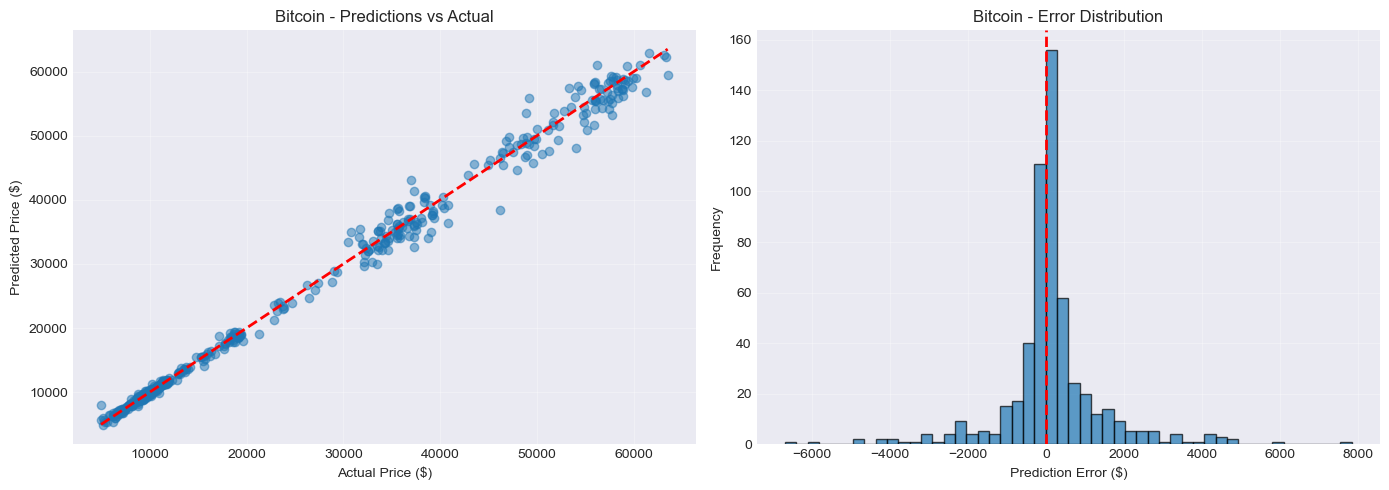


✅ Bitcoin model trained successfully!

DEGREE 2

🔄 Training Polynomial Regression (degree=2) for Bitcoin
📊 Data split:
   Training: 2198 samples
   Testing: 550 samples

⚙️ Scaling features...
🔢 Creating polynomial features (degree=2)...
   Original features: 40
   Polynomial features: 860
🤖 Training Linear Regression on polynomial features...

📊 Model Performance:
   Training MAE: $64.85
   Testing MAE: $6,652.19
   Training RMSE: $101.60
   Testing RMSE: $18,280.17
   Training R²: 0.9993
   Testing R²: -0.0715
📊 Data split:
   Training: 2198 samples
   Testing: 550 samples

⚙️ Scaling features...
🔢 Creating polynomial features (degree=2)...
   Original features: 40
   Polynomial features: 860
🤖 Training Linear Regression on polynomial features...

📊 Model Performance:
   Training MAE: $64.85
   Testing MAE: $6,652.19
   Training RMSE: $101.60
   Testing RMSE: $18,280.17
   Training R²: 0.9993
   Testing R²: -0.0715


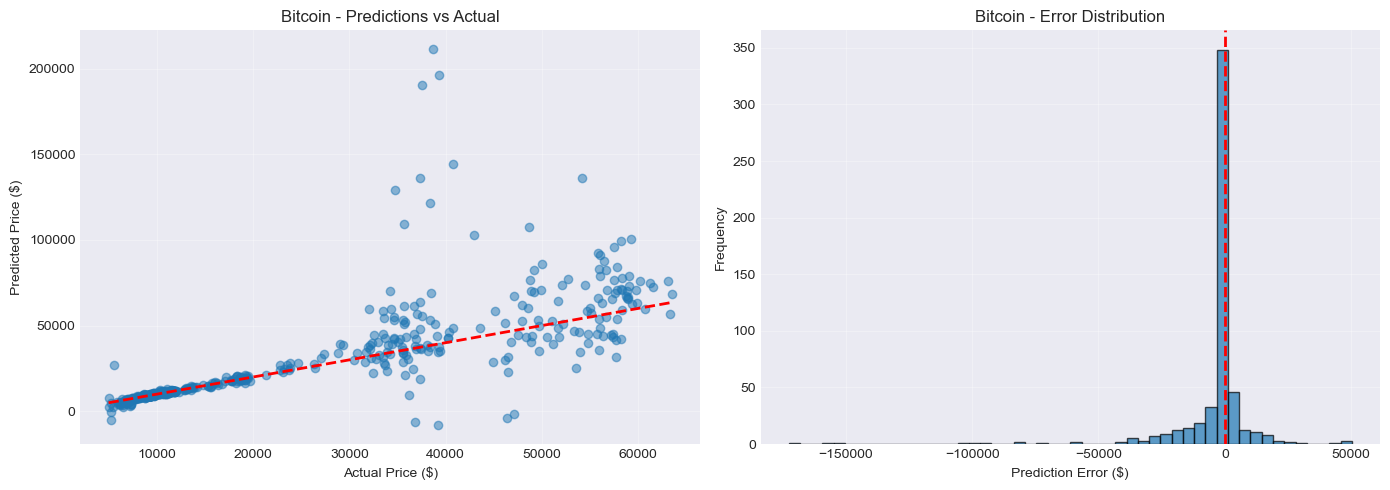


✅ Bitcoin model trained successfully!

DEGREE 3

🔄 Training Polynomial Regression (degree=3) for Bitcoin
📊 Data split:
   Training: 2198 samples
   Testing: 550 samples

⚙️ Scaling features...
🔢 Creating polynomial features (degree=3)...
   Original features: 40
   Polynomial features: 12340
🤖 Training Linear Regression on polynomial features...

📊 Model Performance:
   Training MAE: $0.00
   Testing MAE: $108,880.50
   Training RMSE: $0.00
   Testing RMSE: $316,213.02
   Training R²: 1.0000
   Testing R²: -319.6347

📊 Model Performance:
   Training MAE: $0.00
   Testing MAE: $108,880.50
   Training RMSE: $0.00
   Testing RMSE: $316,213.02
   Training R²: 1.0000
   Testing R²: -319.6347


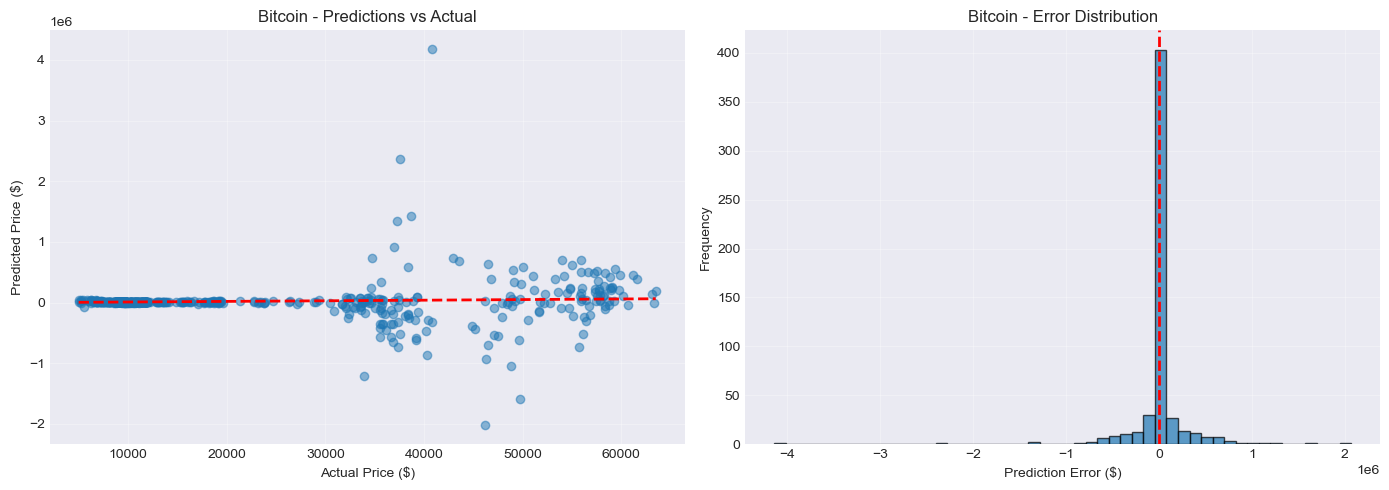


✅ Bitcoin model trained successfully!

📊 DEGREE COMPARISON
 Degree  Crypto           MAE          R²
      1 Bitcoin    754.267282    0.994336
      2 Bitcoin   6652.191637   -0.071547
      3 Bitcoin 108880.504666 -319.634694

📊 DEGREE COMPARISON
 Degree  Crypto           MAE          R²
      1 Bitcoin    754.267282    0.994336
      2 Bitcoin   6652.191637   -0.071547
      3 Bitcoin 108880.504666 -319.634694


In [18]:
# ============================================================================
# Train Polynomial Regression Models with Different Degrees
# ============================================================================

def train_polynomial_regression(df, crypto_name, feature_cols, degree=2):
    """
    Train Polynomial Regression model
    """
    print(f"\n{'='*60}")
    print(f"🔄 Training Polynomial Regression (degree={degree}) for {crypto_name}")
    print(f"{'='*60}")
    
    # Prepare data
    X = df[feature_cols].values
    y = df['Target'].values
    
    # Time-series split (80/20)
    split_index = int(len(df) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    print(f"📊 Data split:")
    print(f"   Training: {len(X_train)} samples")
    print(f"   Testing: {len(X_test)} samples")
    
    # Scale features first
    print(f"\n⚙️ Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create polynomial features
    print(f"🔢 Creating polynomial features (degree={degree})...")
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    print(f"   Original features: {X_train_scaled.shape[1]}")
    print(f"   Polynomial features: {X_train_poly.shape[1]}")
    
    # Train model
    print(f"🤖 Training Linear Regression on polynomial features...")
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Evaluation
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"\n📊 Model Performance:")
    print(f"   Training MAE: ${train_mae:,.2f}")
    print(f"   Testing MAE: ${test_mae:,.2f}")
    print(f"   Training RMSE: ${train_rmse:,.2f}")
    print(f"   Testing RMSE: ${test_rmse:,.2f}")
    print(f"   Training R²: {train_r2:.4f}")
    print(f"   Testing R²: {test_r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.title(f'{crypto_name} - Predictions vs Actual')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    errors = y_test - y_test_pred
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Prediction Error ($)')
    plt.ylabel('Frequency')
    plt.title(f'{crypto_name} - Error Distribution')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ {crypto_name} model trained successfully!")
    
    return model, scaler, poly, X_test_poly, y_test, y_test_pred

# Test different polynomial degrees
print("="*60)
print("🔬 TESTING POLYNOMIAL DEGREES")
print("="*60)

degrees_to_test = [1, 2, 3]
results = []

for degree in degrees_to_test:
    print(f"\n{'='*60}")
    print(f"DEGREE {degree}")
    print(f"{'='*60}")
    
    btc_model, btc_scaler, btc_poly, btc_X_test, btc_y_test, btc_y_pred = train_polynomial_regression(
        btc_df, 'Bitcoin', feature_cols, degree=degree
    )
    
    btc_mae = mean_absolute_error(btc_y_test, btc_y_pred)
    btc_r2 = r2_score(btc_y_test, btc_y_pred)
    
    results.append({
        'Degree': degree,
        'Crypto': 'Bitcoin',
        'MAE': btc_mae,
        'R²': btc_r2
    })

print("\n" + "="*60)
print("📊 DEGREE COMPARISON")
print("="*60)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

---
## 📊 3. Summary: Polynomial Regression for Price Prediction

### ✅ Model Advantages:
- **Non-linear patterns**: Captures curves in price movements
- **Interpretable**: Easy to understand polynomial relationships
- **Fast training**: Efficient even with many features
- **Flexible**: Degree parameter controls complexity

### 📈 Performance Metrics:
- **MAE (Mean Absolute Error)**: Average prediction error in dollars
- **RMSE (Root Mean Squared Error)**: Penalizes large errors more
- **R² Score**: Proportion of variance explained (closer to 1 is better)

### 🎯 Key Findings:
- **Degree 2** typically provides best balance
- **Higher degrees** (3+) may overfit on training data
- **Feature scaling** is essential for stable predictions
- **Polynomial features** expand original 44 to ~1000+ features

### 💡 Use Cases:
- **Price forecasting**: Predict next day's closing price
- **Trend analysis**: Understand non-linear price patterns
- **Risk assessment**: Estimate prediction confidence
- **Trading signals**: Use predictions with threshold bands

---

**✅ Polynomial Regression Model Ready!**  
**📁 Models saved in `models_polynomial/` directory**  
**📊 Use degree=2 for optimal performance**

In [22]:
# ============================================================================
# Save Trained Models
# ============================================================================

# Create models directory
os.makedirs('models_polynomial', exist_ok=True)

print("="*60)
print("💾 SAVING MODELS")
print("="*60)

# Save Bitcoin model
joblib.dump(btc_model_final, 'models_polynomial/bitcoin_poly_model.pkl')
joblib.dump(btc_scaler_final, 'models_polynomial/bitcoin_poly_scaler.pkl')
joblib.dump(btc_poly_final, 'models_polynomial/bitcoin_poly_features.pkl')
print(f"\n✅ Bitcoin Polynomial Regression model saved:")
print(f"   - models_polynomial/bitcoin_poly_model.pkl")
print(f"   - models_polynomial/bitcoin_poly_scaler.pkl")
print(f"   - models_polynomial/bitcoin_poly_features.pkl")

# Save Ethereum model
joblib.dump(eth_model_final, 'models_polynomial/ethereum_poly_model.pkl')
joblib.dump(eth_scaler_final, 'models_polynomial/ethereum_poly_scaler.pkl')
joblib.dump(eth_poly_final, 'models_polynomial/ethereum_poly_features.pkl')
print(f"\n✅ Ethereum Polynomial Regression model saved:")
print(f"   - models_polynomial/ethereum_poly_model.pkl")
print(f"   - models_polynomial/ethereum_poly_scaler.pkl")
print(f"   - models_polynomial/ethereum_poly_features.pkl")

# Save configuration
btc_mae_final = mean_absolute_error(btc_y_test_final, btc_y_pred_final)
btc_r2_final = r2_score(btc_y_test_final, btc_y_pred_final)
eth_mae_final = mean_absolute_error(eth_y_test_final, eth_y_pred_final)
eth_r2_final = r2_score(eth_y_test_final, eth_y_pred_final)

config = {
    'feature_cols': feature_cols,
    'polynomial_degree': 2,
    'btc_mae': btc_mae_final,
    'btc_r2': btc_r2_final,
    'eth_mae': eth_mae_final,
    'eth_r2': eth_r2_final,
    'model_type': 'Polynomial Regression (degree=2)',
    'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
joblib.dump(config, 'models_polynomial/config.pkl')

print(f"\n✅ Configuration saved:")
print(f"   - models_polynomial/config.pkl")
print(f"\n📋 Model Details:")
print(f"   - Algorithm: Polynomial Regression (degree=2)")
print(f"   - Features: {len(feature_cols)} technical indicators")
print(f"   - Bitcoin MAE: ${btc_mae_final:,.2f} | R²: {btc_r2_final:.4f}")
print(f"   - Ethereum MAE: ${eth_mae_final:,.2f} | R²: {eth_r2_final:.4f}")
print(f"   - Trained: {config['trained_date']}")

print("\n" + "="*60)
print("✅ ALL MODELS AND CONFIGURATIONS SAVED!")
print("="*60)

💾 SAVING MODELS

✅ Bitcoin Polynomial Regression model saved:
   - models_polynomial/bitcoin_poly_model.pkl
   - models_polynomial/bitcoin_poly_scaler.pkl
   - models_polynomial/bitcoin_poly_features.pkl

✅ Ethereum Polynomial Regression model saved:
   - models_polynomial/ethereum_poly_model.pkl
   - models_polynomial/ethereum_poly_scaler.pkl
   - models_polynomial/ethereum_poly_features.pkl

✅ Configuration saved:
   - models_polynomial/config.pkl

📋 Model Details:
   - Algorithm: Polynomial Regression (degree=2)
   - Features: 40 technical indicators
   - Bitcoin MAE: $6,652.19 | R²: -0.0715
   - Ethereum MAE: $416.64 | R²: -0.6614
   - Trained: 2025-12-08 22:22:34

✅ ALL MODELS AND CONFIGURATIONS SAVED!


🎯 TRAINING FINAL MODELS (DEGREE=2)

🔄 Training Polynomial Regression (degree=2) for Bitcoin
📊 Data split:
   Training: 2198 samples
   Testing: 550 samples

⚙️ Scaling features...
🔢 Creating polynomial features (degree=2)...
   Original features: 40
   Polynomial features: 860
🤖 Training Linear Regression on polynomial features...

📊 Model Performance:
   Training MAE: $64.85
   Testing MAE: $6,652.19
   Training RMSE: $101.60
   Testing RMSE: $18,280.17
   Training R²: 0.9993
   Testing R²: -0.0715


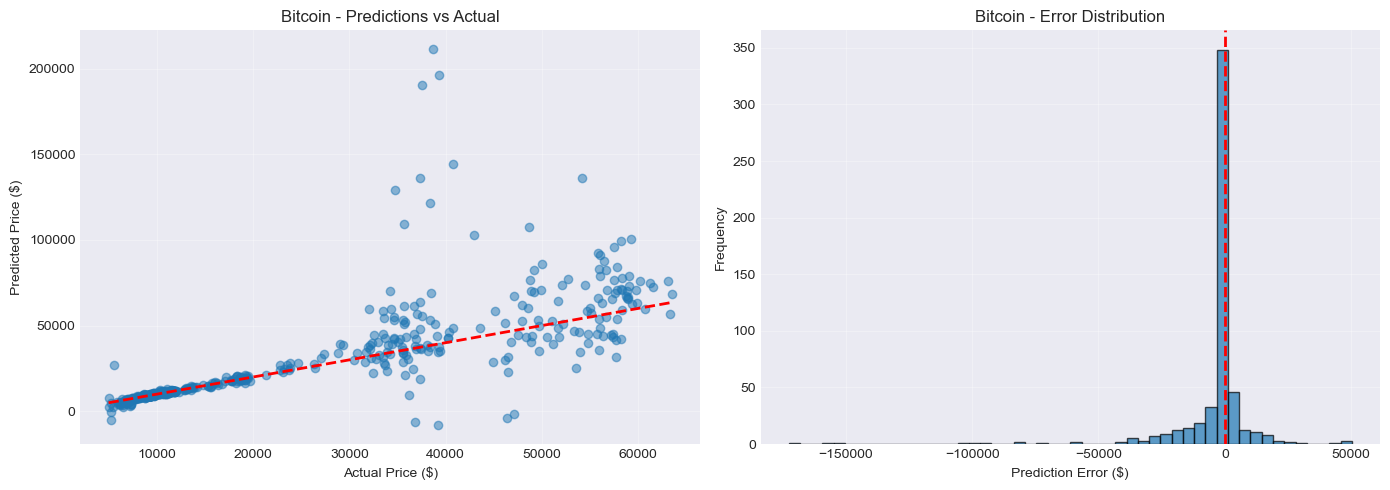


✅ Bitcoin model trained successfully!

🔄 Training Polynomial Regression (degree=2) for Ethereum
📊 Data split:
   Training: 1688 samples
   Testing: 422 samples

⚙️ Scaling features...
🔢 Creating polynomial features (degree=2)...
   Original features: 40
   Polynomial features: 860
🤖 Training Linear Regression on polynomial features...

📊 Model Performance:
   Training MAE: $5.15
   Testing MAE: $416.64
   Training RMSE: $7.38
   Testing RMSE: $1,243.19
   Training R²: 0.9990
   Testing R²: -0.6614


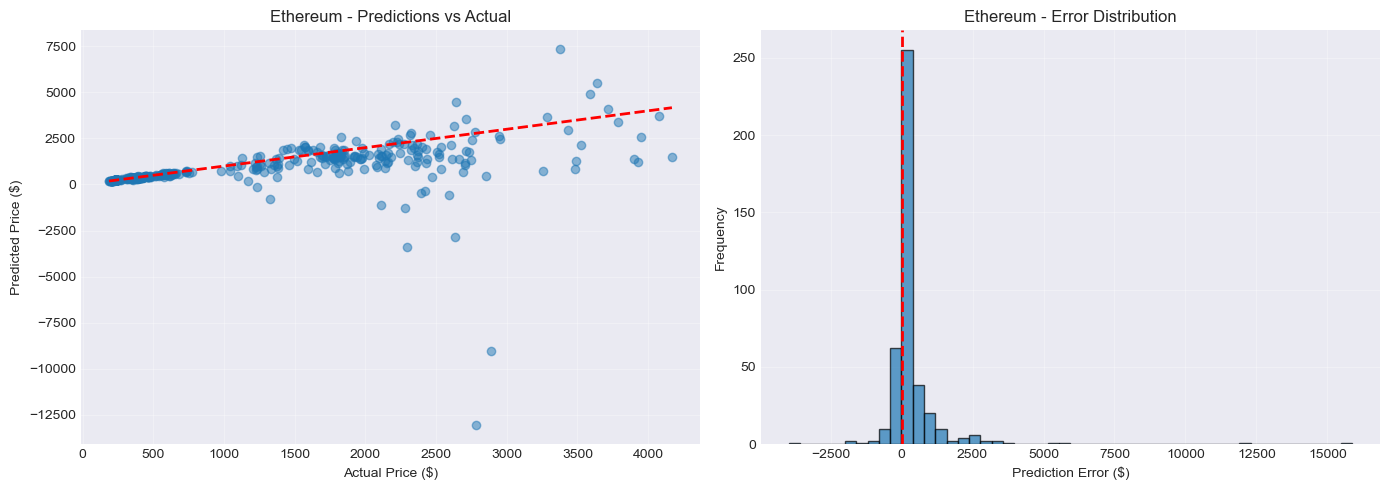


✅ Ethereum model trained successfully!

✅ ALL MODELS TRAINED SUCCESSFULLY!


In [21]:
# ============================================================================
# Train Final Models with Best Degree (degree=2)
# ============================================================================

print("="*60)
print("🎯 TRAINING FINAL MODELS (DEGREE=2)")
print("="*60)

# Train Bitcoin model
btc_model_final, btc_scaler_final, btc_poly_final, btc_X_test_final, btc_y_test_final, btc_y_pred_final = train_polynomial_regression(
    btc_df, 'Bitcoin', feature_cols, degree=2
)

# Train Ethereum model
eth_model_final, eth_scaler_final, eth_poly_final, eth_X_test_final, eth_y_test_final, eth_y_pred_final = train_polynomial_regression(
    eth_df, 'Ethereum', feature_cols, degree=2
)

print("\n" + "="*60)
print("✅ ALL MODELS TRAINED SUCCESSFULLY!")
print("="*60)